## Análise de satisfação de clientes de E-commerce
Nesse projeto, precisamos captar a satisfação dos clientes com base em suas avaliações numa plataforma de e-commerce. Compreender o sentimento por trás dos comentários ajudará a empresa identificar preferências, satisfaçõe ou insatisfações dos clientes. Os insights obtidos podem ser usados para melhorar o serviço e a experiência do cliente.

### Importação de bibliotecas

In [1]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Ferramentas de PLN para processamento de texto
import re, nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

# Pacotes de modelagem de dados
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [ ]:
import nltk

# Força o caminho certo para a pasta onde os dados do NLTK estão
nltk.data.path.append('C:/Users/Ralissa/AppData/Roaming/nltk_data')

# Garante que 'punkt' e 'stopwords' estão mesmo disponíveis
nltk.download('punkt')
nltk.download('stopwords')

### Importação e Análise Exploratória dos Dados

In [2]:
# Importando dados
df = pd.read_csv('olist_order_reviews_dataset.csv')

In [4]:
# Visualização geral
df.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [5]:
# Tamanho do dataset
df.shape

(99224, 7)

In [6]:
# Verificando valores nulos
df.isnull().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

In [7]:
# Verificando valores duplicados
# Não há valores duplicados
df.duplicated().sum()

0

### 3. Pré-processamento dos dados
O conjunto de dados possui muitos valores nulos no título e no texto das avaliações. Precisaremos eliminar valores ausentes e redefinir o índice dos dados.

In [8]:
# Avaliando separadamente as variáveis título e descrição da avaliação
review_data_title = df['review_comment_title'] # título das avaliações
review_data = df.drop(['review_comment_title'],axis=1) # avaliações

In [9]:
# Eliminando valores nulos
review_data = review_data.dropna()
review_data_title = review_data_title.dropna()

In [10]:
# Exibindo títulos das avaliações após exclusão de nulos
review_data_title 

9                        recomendo
15                 Super recomendo
19         Não chegou meu produto 
22                           Ótimo
34                      Muito bom.
                   ...            
99192                            👍
99196           muito bom produto 
99197    Não foi entregue o pedido
99199              OTIMA EMBALAGEM
99200               Foto enganosa 
Name: review_comment_title, Length: 11568, dtype: object

In [11]:
# Exibindo avaliações após exclusão de nulos
review_data.head()

,review_id,order_id,review_score,review_comment_message,review_creation_date,review_answer_timestamp
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47
12,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",2018-02-16 00:00:00,2018-02-20 10:52:22
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,"Vendedor confiável, produto ok e entrega antes...",2018-05-23 00:00:00,2018-05-24 03:00:01


In [12]:
# Reorganizando o index das avaliações
review_data = review_data.reset_index(drop=True)
review_data.head(3)
review_data.shape

,review_id,order_id,review_score,review_comment_message,review_creation_date,review_answer_timestamp
0,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
1,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
2,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47


(40977, 6)

In [13]:
# Reorganizando o index dos títulos das avaliações
review_data_title = review_data_title.reset_index(drop=True)
review_data_title.head(3)
review_data_title.shape

0                  recomendo
1            Super recomendo
2    Não chegou meu produto 
Name: review_comment_title, dtype: object

(11568,)

#### Conclusões
1. 58% dos clientes não deixaram comentários (apenas x% de clientes deixaram comentários)
2. Apenas 11% dos clientes deixaram comentários com títulos

Agora, iremos pré-processar as revisões e os títulos para visualização e modelagem

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

In [14]:
comments = []
stop_words = set(stopwords.words('portuguese'))

for words in review_data['review_comment_message']:
    words = str(words)  # <-- garante que seja string
    only_letters = re.sub(r'[^a-zA-ZÀ-ÿ]', ' ', words)
    tokens = nltk.word_tokenize(only_letters)
    lower_case = [l.lower() for l in tokens]
    filtered_result = [l for l in lower_case if l not in stop_words]
    comments.append(' '.join(filtered_result))

In [15]:
comments[0:11]

['recebi bem antes prazo estipulado',
 'parabéns lojas lannister adorei comprar internet seguro prático parabéns todos feliz páscoa',
 'aparelho eficiente site marca aparelho impresso desinfector chegar outro nome atualizar marca correta vez aparelho',
 'pouco travando valor ta boa',
 'vendedor confiável produto ok entrega antes prazo',
 'gostaria saber sempre recebi compra agora decpcionou',
 'péssimo',
 'loja nota',
 'obrigado atençao amim dispensada',
 'compra realizada facilmente entrega efetuada antes prazo dado produto começou usado presente problemas',
 'relógio bonito barato']

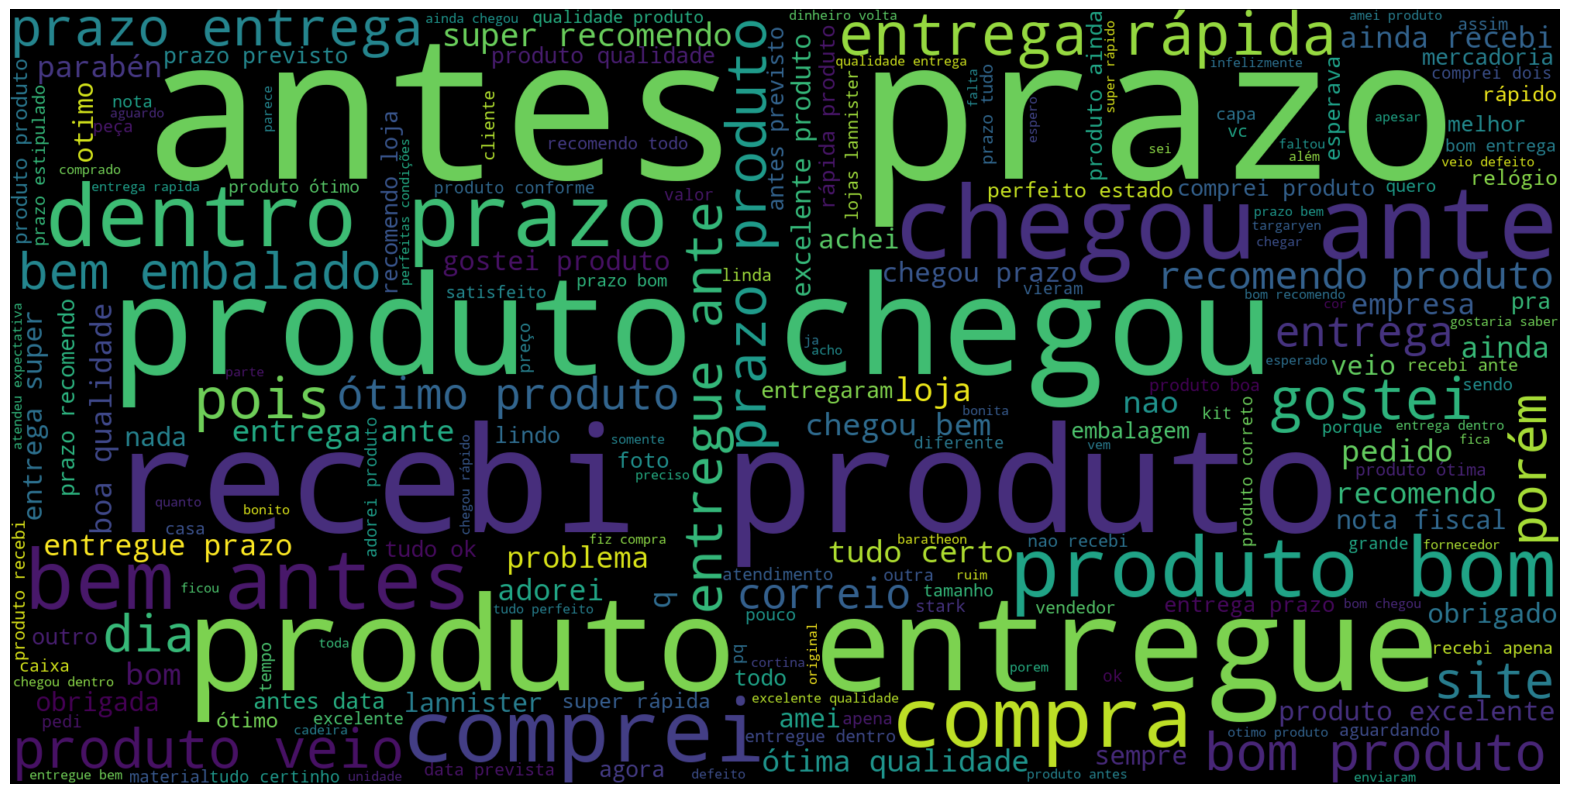

In [16]:
# Aplicando wordcloud para visualizar os dados
unique_string= (' ').join(comments)
wordcloud = WordCloud(width=2000, height=1000).generate(unique_string)
plt.figure(figsize=(20,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show();

In [17]:
# Usando CountVectorizer para pegar as palavras mais importantes
cv = CountVectorizer(ngram_range=(1,1))
counts = cv.fit_transform(comments)
important_unigrams = pd.DataFrame(counts.sum(axis=0), columns=cv.get_feature_names_out()).T.sort_values(0, ascending=False)

In [18]:
important_unigrams

,0
produto,18429
prazo,8475
entrega,6532
antes,5626
chegou,5555
...,...
fragia,1
fragiu,1
fragrâncias,1
fraldas,1


In [19]:
# Vamos resetar o index, renomear as colunas e aplicar o módulo de tradução para 
important_unigrams = important_unigrams.reset_index()
important_unigrams.rename(columns={'index':'unigrams', 0:'frequency'}, inplace=True)

In [20]:
# Usando o CountVectorizer para pegar os mais importantes trigrams
cv = CountVectorizer(ngram_range=(3,3))
counts = cv.fit_transform(comments)
important_trigrams = pd.DataFrame(counts.sum(axis=0), columns=cv.get_feature_names_out()).T.sort_values(0, ascending=False)

In [21]:
important_trigrams

,0
chegou antes prazo,1142
bem antes prazo,706
entregue antes prazo,620
produto chegou antes,464
entrega antes prazo,441
...,...
entregou mercadoria antes,1
entregou mercadoria tempo,1
entregou metade pedido,1
entregou muiiiito rápido,1


In [22]:
# Agora vamos resetar novamente o index, renomear as colunas e aplicar a tradução em inglês nas palavras
important_trigrams = important_trigrams.reset_index()
important_trigrams.rename(columns={'index':'trigrams',0:'frequency'}, inplace=True)

In [23]:
important_trigrams

,trigrams,frequency
0,chegou antes prazo,1142
1,bem antes prazo,706
2,entregue antes prazo,620
3,produto chegou antes,464
4,entrega antes prazo,441
...,...,...
161268,entregou mercadoria antes,1
161269,entregou mercadoria tempo,1
161270,entregou metade pedido,1
161271,entregou muiiiito rápido,1


#### Conclusões
De acordo com os unigramas, bigramas e trigramas, podemos afirmar que a maioria dos clientes ficou satisfeita com o serviço de entrega e qualidade dos produtos. Vamos nos aprofundar também nos clientes que não ficaram satisfeitos

In [24]:
# Verificando pontuações antes de remover os valores nulos
df['review_score'].value_counts()

review_score
5    57328
4    19142
1    11424
3     8179
2     3151
Name: count, dtype: int64

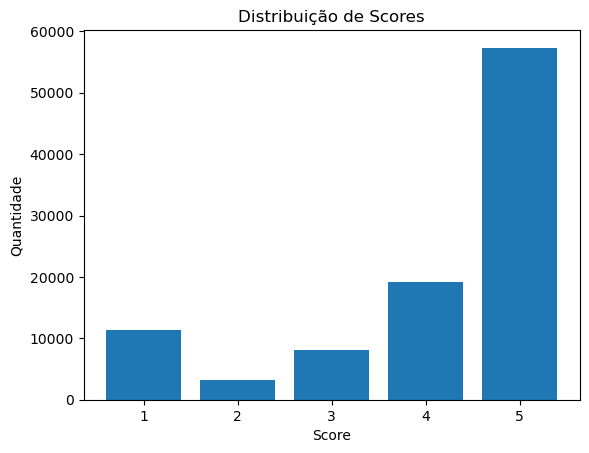

In [25]:
import matplotlib.pyplot as plt

# Conta os scores
contagem = df['review_score'].value_counts().sort_index()

# Gráfico simples
plt.bar(contagem.index, contagem.values)
plt.xlabel('Score')
plt.ylabel('Quantidade')
plt.title('Distribuição de Scores')
plt.show();

In [26]:
# Verificando pontuações depois de remover os valores nulos
review_data['review_score'].value_counts()

review_score
5    20554
1     8745
4     5976
3     3557
2     2145
Name: count, dtype: int64

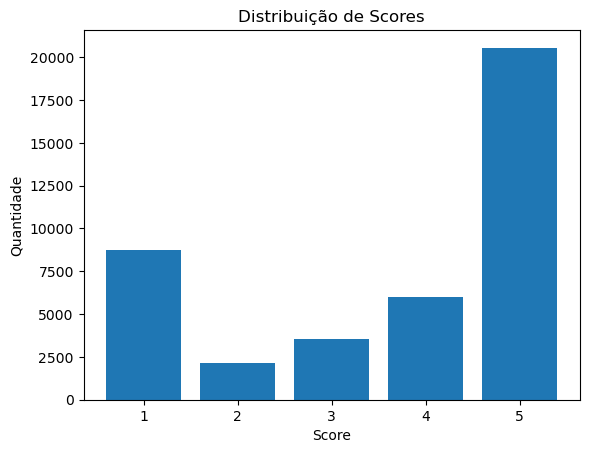

In [27]:
# Conta os scores
contagem = review_data['review_score'].value_counts().sort_index()

# Gráfico simples
plt.bar(contagem.index, contagem.values)
plt.xlabel('Score')
plt.ylabel('Quantidade')
plt.title('Distribuição de Scores')
plt.show();

#### Conclusões
Após a remoção de valores nulos, temos que cerca de 10.000 pessoas deram 1 estrela e pouco mais de 20.000 deram 5 estrelas, o que indica:
1. Cerca de 36% dos revisores de 5 estrelas deram comentários enquanto 79% dos revisores de 1 estrela deram comentários, então um cliente é mais propenso a fazer um comentário quando está insatisfeito com o produto.

In [28]:
# Verificando os títulos das reviews
comments_titles = []
stop_words = set(stopwords.words('portuguese'))

for words in review_data_title:
    only_letters = re.sub(r'[^a-zA-ZÀ-ÿ]', ' ', words)
    tokens = nltk.word_tokenize(only_letters)
    lower_case = [l.lower() for l in tokens]
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))

    comments_titles.append(' '.join(filtered_result))

In [34]:
comments_titles[0:11]

['recomendo',
 'super recomendo',
 'chegou produto',
 'ótimo',
 'bom',
 'bom',
 'maravilhoso',
 'entrega perfeita',
 'ótimo',
 'mt lindo',
 'ótimo produto']

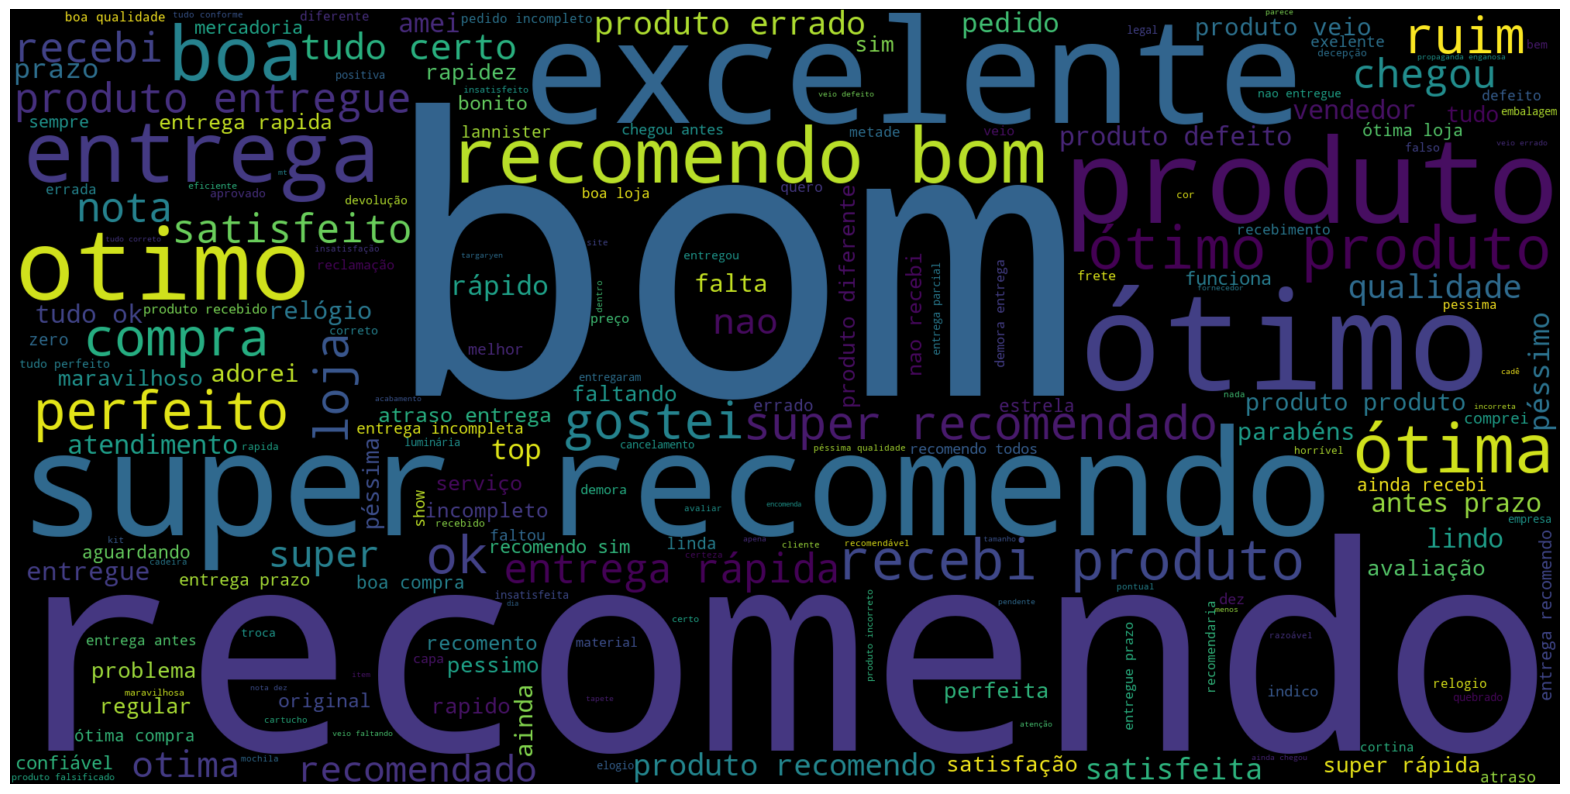

In [30]:
# Usando wordcloud para visualizar o título das avaliações
unique_string= (' ').join(comments_titles)
wordcloud = WordCloud(width=2000, height=1000).generate(unique_string)
plt.figure(figsize=(20,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show();

In [31]:
# Usando o CountVectorizer para obter os unigramas mais importantes
cv = CountVectorizer(ngram_range=(1,1))
counts = cv.fit_transform(comments_titles)
important_unigrams_title = pd.DataFrame(counts.sum(axis=0), columns=cv.get_feature_names_out()).T.sort_values(0, ascending=False).head(50)

In [32]:
important_unigrams_title = important_unigrams_title.reset_index()
important_unigrams_title.rename(columns = {'index':'unigrams_title', 0:'frequency'}, inplace=True)

important_unigrams_title.head()

,unigrams_title,frequency
0,recomendo,2071
1,bom,1315
2,produto,1290
3,super,896
4,ótimo,725


In [35]:
# Usando o CountVectorizer para obter os bigramas mais importantes
cv = CountVectorizer(ngram_range=(2,2))
counts = cv.fit_transform(comments_titles)
important_bigrams_title = pd.DataFrame(counts.sum(axis=0), columns=cv.get_feature_names_out()).T.sort_values(0, ascending=False).head(50)

In [36]:
important_bigrams_title = important_bigrams_title.reset_index()
important_bigrams_title.rename(columns = {'index':'bigrams_title', 0:'frequency'}, inplace=True)
important_bigrams_title.head()

,bigrams_title,frequency
0,super recomendo,678
1,recebi produto,121
2,ótimo produto,102
3,super recomendado,101
4,produto entregue,98


In [37]:
# Usando o CountVectorizer para obter os bigramas mais importantes
cv = CountVectorizer(ngram_range=(3,3))
counts = cv.fit_transform(comments_titles)
important_trigrams_title = pd.DataFrame(counts.sum(axis=0), columns=cv.get_feature_names_out()).T.sort_values(0, ascending=False).head(50)

In [38]:
important_trigrams_title = important_trigrams_title.reset_index()
important_trigrams_title.rename(columns = {'index':'trigrams_title', 0:'frequency'}, inplace=True)
important_trigrams_title.head()

,trigrams_title,frequency
0,entrega super rápida,27
1,entrega antes prazo,15
2,chegou antes prazo,11
3,nao recebi produto,11
4,produto entregue prazo,8


In [ ]:
## Priorizar a entrega
## Perdir tres ou 4 palavras pro cliente pois já é o bastante pra se aprofundar. Resumir em 5 palavras, algo assim

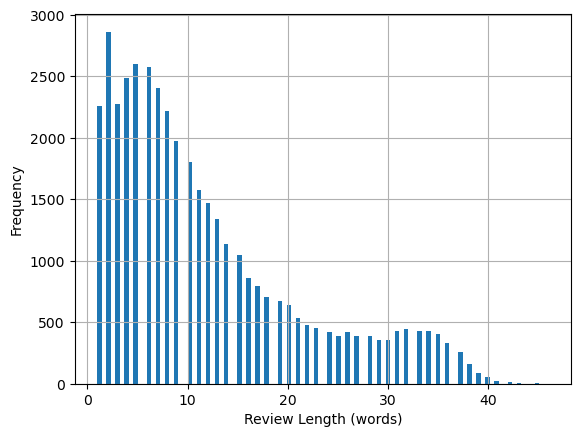

In [39]:
# Getting the number of words by splitting them by a space
words_per_review = review_data.review_comment_message.apply(lambda x: len(x.split(' ')))
words_per_review.hist(bins = 100)
plt.xlabel('Review Length (words)')
plt.ylabel('Frequency')
plt.show();

In [40]:
print('Average words:', words_per_review.mean())
print('Skew:', words_per_review.skew())

Average words: 11.81687287990824
Skew: 1.0980395858627507


In [41]:
# Checando a percentagem de score das avaliações
percent_scores = 100 * review_data['review_score'].value_counts()/len(review_data)
percent_scores

review_score
5    50.159846
1    21.341240
4    14.583791
3     8.680479
2     5.234644
Name: count, dtype: float64

### 4. Máquina preditiva de análise de sentimentos
Aqui seria um caso de aprendizado supervisionado, teríamos que criar uma nova coluna representando a pontuação de sentimento (0 para negativo e 1 para positivo). Excluiremos as avaliações de 3 pontos porque representa avaliação neutra. Incluiremos as pontuações 1 e 2 como palavras negativas e as pontuadas 4 e 5 na revisão de palavras positivas.

In [42]:
# Mapeando os ratings
#se score > 3 = 1 (positivo), senão 0 (negativo)
review_data['Sentiment_ranting'] = np.where(review_data.review_score > 3,1,0)

# Removendo avaliações neutras, selecionando apenas valores diferentes de 3
review_data = review_data[review_data.review_score != 3]

# Exibindo a contagem de cada classificação
review_data['Sentiment_ranting'].value_counts()

Sentiment_ranting
1    26530
0    10890
Name: count, dtype: int64

In [43]:
# Verificando dados após remoção de avaliações neutras
review_data.head()
review_data['Sentiment_ranting'].shape

,review_id,order_id,review_score,review_comment_message,review_creation_date,review_answer_timestamp,Sentiment_ranting
0,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,1
1,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53,1
2,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47,1
3,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",2018-02-16 00:00:00,2018-02-20 10:52:22,1
4,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,"Vendedor confiável, produto ok e entrega antes...",2018-05-23 00:00:00,2018-05-24 03:00:01,1


(37420,)

In [44]:

comments = []
stop_words = set(stopwords.words('portuguese'))

for words in review_data['review_comment_message']:
    only_letters = re.sub(r'[^a-zA-ZÀ-ÿ]', ' ', words)
    tokens = nltk.word_tokenize(only_letters)
    lower_case = [l.lower() for l in tokens]
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))

    comments.append(' '.join(filtered_result))

In [45]:
stopwords_pt = stopwords.words('portuguese')

cv_counts = CountVectorizer(stop_words = stopwords_pt, ngram_range =(1,4))
cv_data = cv_counts.fit_transform(comments)

In [46]:
cv_data

<37420x395245 sparse matrix of type '<class 'numpy.int64'>'
	with 805442 stored elements in Compressed Sparse Row format>

In [ ]:
# Separando dados em treino e teste
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(cv_data, review_data['Sentiment_ranting'], test_size = 0.2, random_state=7)

In [ ]:
# 70% sentiments = positive; 30% sentiments = negative
y_test_cv.value_counts()/y_test_cv.shape[0]

In [ ]:
## INCLUIR AQUI CLASSIFICAÇÃO DE DIFERENTES MODELOS PARA ISSO

In [ ]:
# Definindo o modelo de treino e teste
lr_model = LogisticRegression()
lr_model.fit(X_train_cv, y_train_cv)

In [ ]:
### 5. Avaliação da Máquina
test_pred = lr_model.predict(X_test_cv)

print('Acurácia:', accuracy_score(y_test_cv, test_pred))
print('F1 Score:', f1_score(y_test_cv, test_pred))
print('Confusion Matrix:', confusion_matrix(y_test_cv, test_pred))

In [ ]:
lr_weights = pd.DataFrame(list(zip(cv_counts.get_feature_names_out(),
                                  lr_model.coef_[0])),
                         columns = ['words', 'weights'])

Positive_sentiments = pd.DataFrame(lr_weights.sort_values(['weights'], ascending=False)[:15])
Positive_sentiments.head(20)

In [ ]:
Negative_sentiments = pd.DataFrame(lr_weights.sort_values(['weights'], ascending=False)[-15:])
Negative_sentiments.head(20)

In [ ]:
# nova frase
nova_frase = ["Não chegou meu produto "]

# transforme a frase com o mesmo CountVectorizer usado no treino
nova_frase_cv = cv_counts.transform(nova_frase)

# previsão com o modelo trein ado
predicao = lr_model.predict(nova_frase_cv)

# resultado
print("Predição:", "Positiva" if predicao[0] == 1 else "Negativa")

In [ ]:
import joblib

# Salva o modelo e o vetor de contagem
joblib.dump(lr_model, 'modelo_logistico.pkl')
joblib.dump(cv_counts, 'vetor_countvectorizer.pkl')